In [1]:
import yfinance as yf
import pandas   as pd
import numpy    as np 

In [2]:
btc = yf.Ticker("BTC-USD").history(period="30y")

btc_levels = btc['Close'].copy()
btc_levels

Date
2014-09-17      457.334015
2014-09-18      424.440002
2014-09-19      394.795990
2014-09-20      408.903992
2014-09-21      398.821014
                  ...     
2022-08-12    24402.818359
2022-08-13    24424.068359
2022-08-14    24319.333984
2022-08-15    24136.972656
2022-08-16    23942.691406
Name: Close, Length: 2891, dtype: float64

In [3]:
eth = yf.Ticker("ETH-USD").history(period="30y")

eth_levels = btc['Close'].copy()

ldo = yf.Ticker("LDO-USD").history(period="30y")

ldo_levels = btc['Close'].copy()

In [4]:
def sma(data_levels,params = 50):
    
    data = pd.DataFrame(data_levels).copy()
    
    data['SMA_{}'.format(params)]  = data.iloc[:,0].rolling(params).mean()
    data['Returns'] = data.iloc[:,0].pct_change()
    data = data.dropna()

    signals = []

    for i in range(len(data)):
        
        ## if SMA > current price = buy
        if data.iloc[:,0].iloc[i] > data.iloc[:,1].iloc[i]:
            signals.append(1)
        
        # if SMA < current price = sell
        if data.iloc[:,0].iloc[i] < data.iloc[:,1].iloc[i]:
            signals.append(0)
            
        # if SMA == current price = do nothing (this wont happen)
        if data.iloc[:,0].iloc[i] == data.iloc[:,1].iloc[i]:
            print('test')
            signals.append(0)
            
    data['Signals'] = signals
    
    return data

,Close,SMA_50,Returns,Signals
Date,,,,
2014-11-05,339.485992,372.766840,0.027214,0
2014-11-06,349.290009,370.605960,0.028879,0
2014-11-07,342.415009,368.965460,-0.019683,0
2014-11-08,345.488007,367.979301,0.008974,0
2014-11-09,363.264008,367.066501,0.051452,0
...,...,...,...,...
2022-08-12,24402.818359,21857.221641,0.018587,1
2022-08-13,24424.068359,21921.069883,0.000871,1
2022-08-14,24319.333984,21977.409805,-0.004288,1


<AxesSubplot:xlabel='Date'>

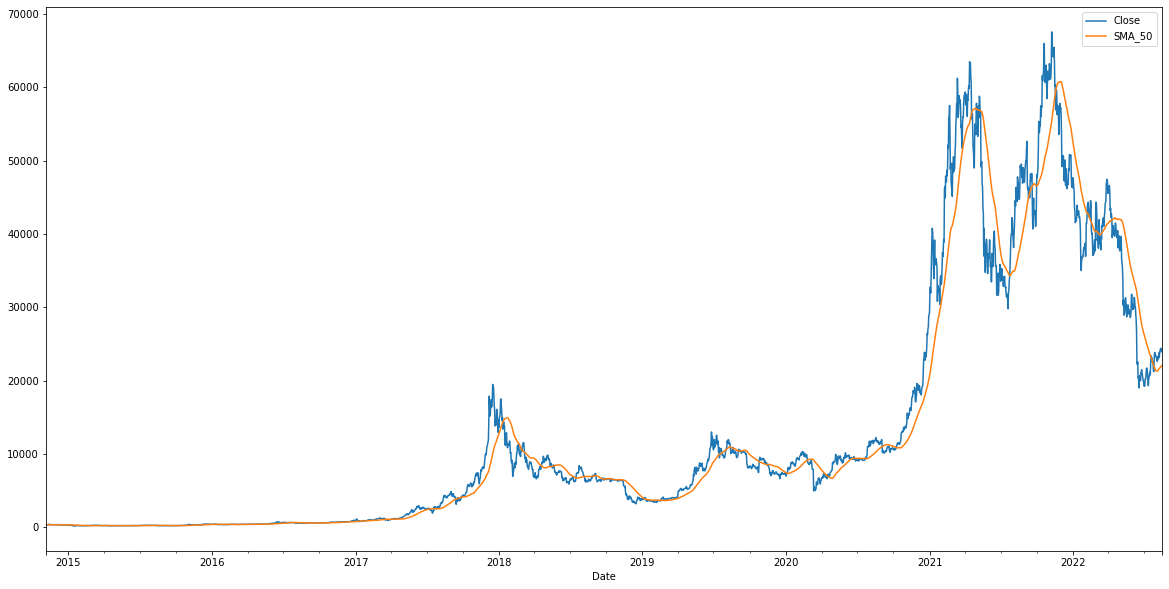

In [5]:
df = sma(btc_levels)

display(df)

df[['Close','SMA_50']].plot(figsize = (20,10))

In [6]:
def backtester(signals,price, tcost = 0.005):

        pos_val = np.zeros(np.shape(price))
        cash    = np.zeros(np.shape(price))
        cash[0] = 1

        for i,val in enumerate(price):

            if i == len(price)-1:
                break


            if signals[i] == 0:

                cash[i+1] = (pos_val[i] * val * (1-tcost)) + cash[i]
                pos_val[i+1] = 0

            elif signals[i] == 1:

                pos_val[i+1] = (cash[i] / val)*((1-tcost)) + pos_val[i]
                cash[i+1] = 0


        returns = [a*b for a,b in zip(pos_val,price)] + cash
        
        return pd.DataFrame(returns, index = price.index)

In [7]:
returns = backtester(df['Signals'],df['Close'])



<AxesSubplot:xlabel='Date'>

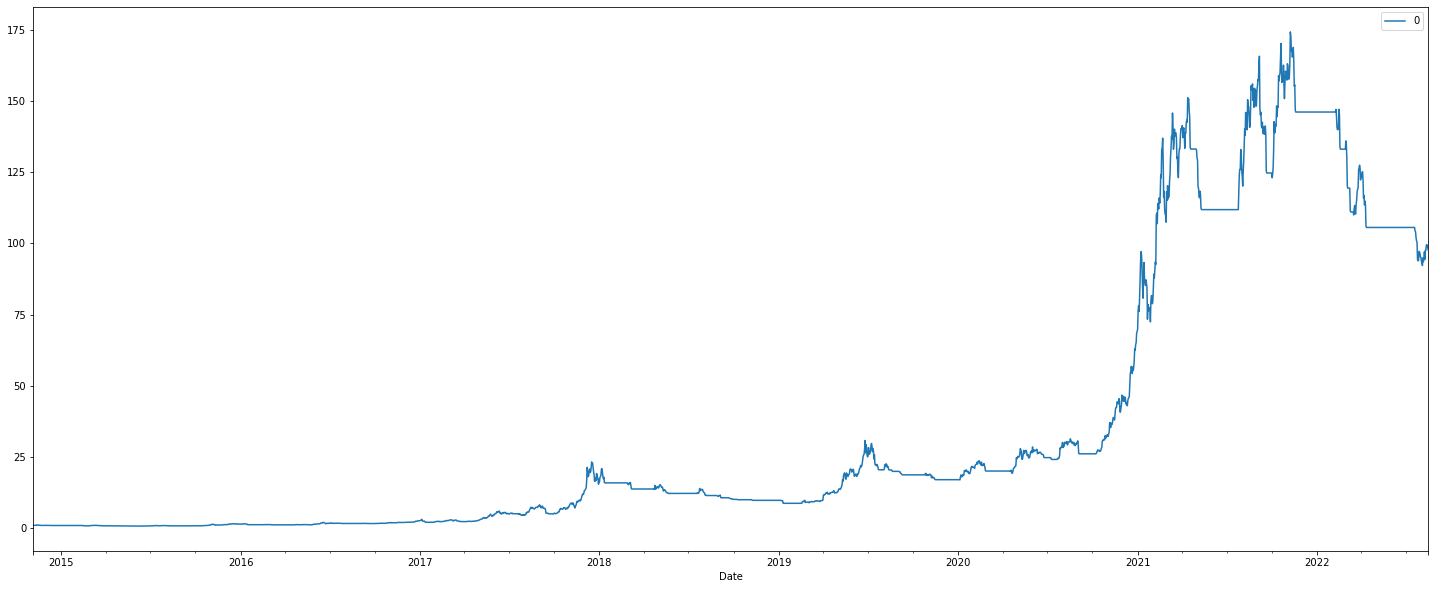

In [8]:
returns.plot(figsize = (25,10))

In [9]:
def win_rate(sigs, returns):
    
    """
    Signals : series
    returns : series
    must be same length
    """
    
    tps = []

    sigs = sigs[1:-1].values.ravel()

    rets = (returns.pct_change()).shift(1).dropna().values.ravel()

    for i,val in enumerate(sigs):

        if (sigs[i] == 1 and rets[i]>0):
            tps.append(1)

    win_rate = sum(tps)/len(sigs)
    return win_rate

win_rate(df['Signals'], returns)

0.31795774647887326

# Lets test a coin toss lol

<AxesSubplot:xlabel='Date'>

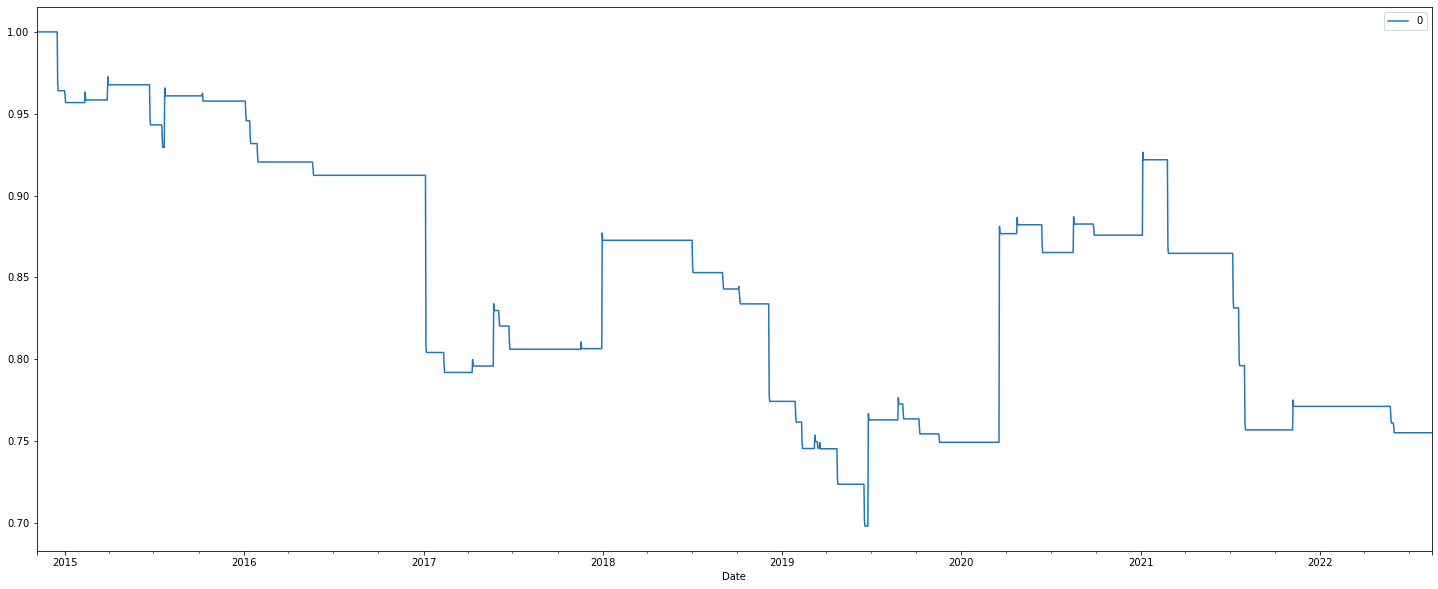

In [10]:
import random

k = 50
n = len(df['Close'])

random.seed(6154319444916832704)  

output = sorted([1] * k + [0] * (n - k), key=lambda k: random.random())



ret_ct = backtester(output,df['Close'])

ret_ct.plot(figsize = (25,10))





In [11]:
win_rate(pd.Series(output), ret_ct)

0.0

In [20]:
def max_dd(returns, window=None):

    data = (1+pd.Series(returns)).cumprod()

    if window is not None:
        roll_max = data.rolling(window, min_periods=1).max()
    else:
        roll_max = data.expanding().max()

    daily = data/roll_max - 1.0

    return min(daily)

In [21]:
max_dd(df['Close'].pct_change().dropna())

-0.8339900882218976

# Lets find the lowest drawdown & best win rate for SMA

In [14]:
sma_windows = np.arange(5,205,5)

drawdowns = []
win_rates = []

for i in sma_windows:
    
    temp = sma(btc_levels,i)
    returns = backtester(temp['Signals'],temp['Close'])
    
    drawdowns.append(max_dd(returns.pct_change().dropna().values.ravel()))
    win_rates.append(win_rate(temp['Signals'], returns))
    


In [23]:
sma_windows[drawdowns.index(max(drawdowns))]

115

In [16]:
max(drawdowns)

-0.5771612626666023

In [24]:
sma_windows[win_rates.index(max(win_rates))]

200

In [18]:
max(win_rates)

0.34349442379182155

<AxesSubplot:xlabel='Date'>

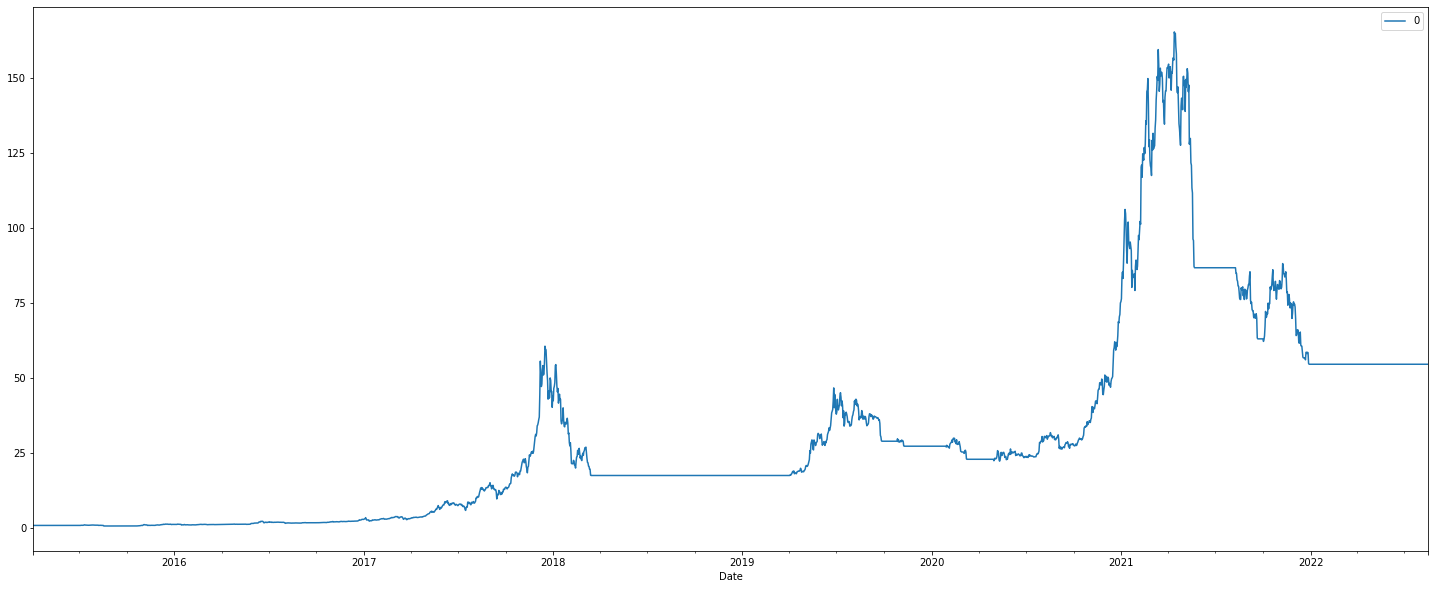

In [25]:
temp = sma(btc_levels,200)
returns = backtester(temp['Signals'],temp['Close'])
returns.plot(figsize = (25,10))